# Analyzing the energy budget of Siberia (using MERRA-2)
What is it like normally? What changed in 2020?

Maybe should do bar chart like in England et. al. paper about MHWs

In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr
import cartopy
import seaborn as sns
import matplotlib as mpl
import math
import calendar
from matplotlib import pyplot as plt
from scipy import stats, signal

import stats_mca_gemini as smg
import plot_mca as plt_mca

# Land (soil moisture, soil temperature, surface latent)

need to redownload soil moisture GWETTOP for top 0cm-5cm soil depth to match 0-7cm of era5 data. currently have entire profile from surface to bedrock

## Analysis

In [7]:
path = '../../data0/yvu/MERRA-2/land/' 
file = "merged-MERRA2LND.nc4"# just 2-m temperature
ds = xr.open_dataset(path+file).sortby('time')
file = '../MERRA2_101.const_2d_asm_Nx.00000000.nc4'# constants (land-sea mask, geopotential height, etc.)
constants = xr.open_dataset(path+file)
lsm = constants.FRLAND.squeeze(dim='time')
constants.close()

ds = ds * lsm

In [8]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:   (lat: 361, lon: 576, time: 540)
Coordinates:
  * lat       (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 4kB 1980-01-01T00:30:00 ... 2024-12-01T00...
Data variables:
    GWETPROF  (time, lat, lon) float32 449MB nan nan nan nan ... nan nan nan nan
    GWETTOP   (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LHLAND    (time, lat, lon) float32 449MB nan nan nan nan ... nan nan nan nan
    LWLAND    (time, lat, lon) float32 449MB nan nan nan nan ... nan nan nan nan
    SHLAND    (time, lat, lon) float32 449MB nan nan nan nan ... nan nan nan nan
    SWLAND    (time, lat, lon) float32 449MB nan nan nan nan ... nan nan nan nan
    TSOIL1    (time, lat, lon) float32 449MB nan nan nan nan ... nan nan nan nan
Attributes: (12/34)
    History:                           Wed Dec 10 22:26:43 2025: ncrcat MERRA...
    Filename:                          MERRA2_100.tavgM_2d_lnd_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000
    history:                           2025-12-10 23:41:10 GMT hyrax-1.17.1 h...
    history_json:                      [{"$schema":"https:\/\/harmony.earthda...
    DODS_EXTRA.Unlimited_Dimension:    time
    NCO:                               netCDF Operators version 5.0.6 (Homepa...

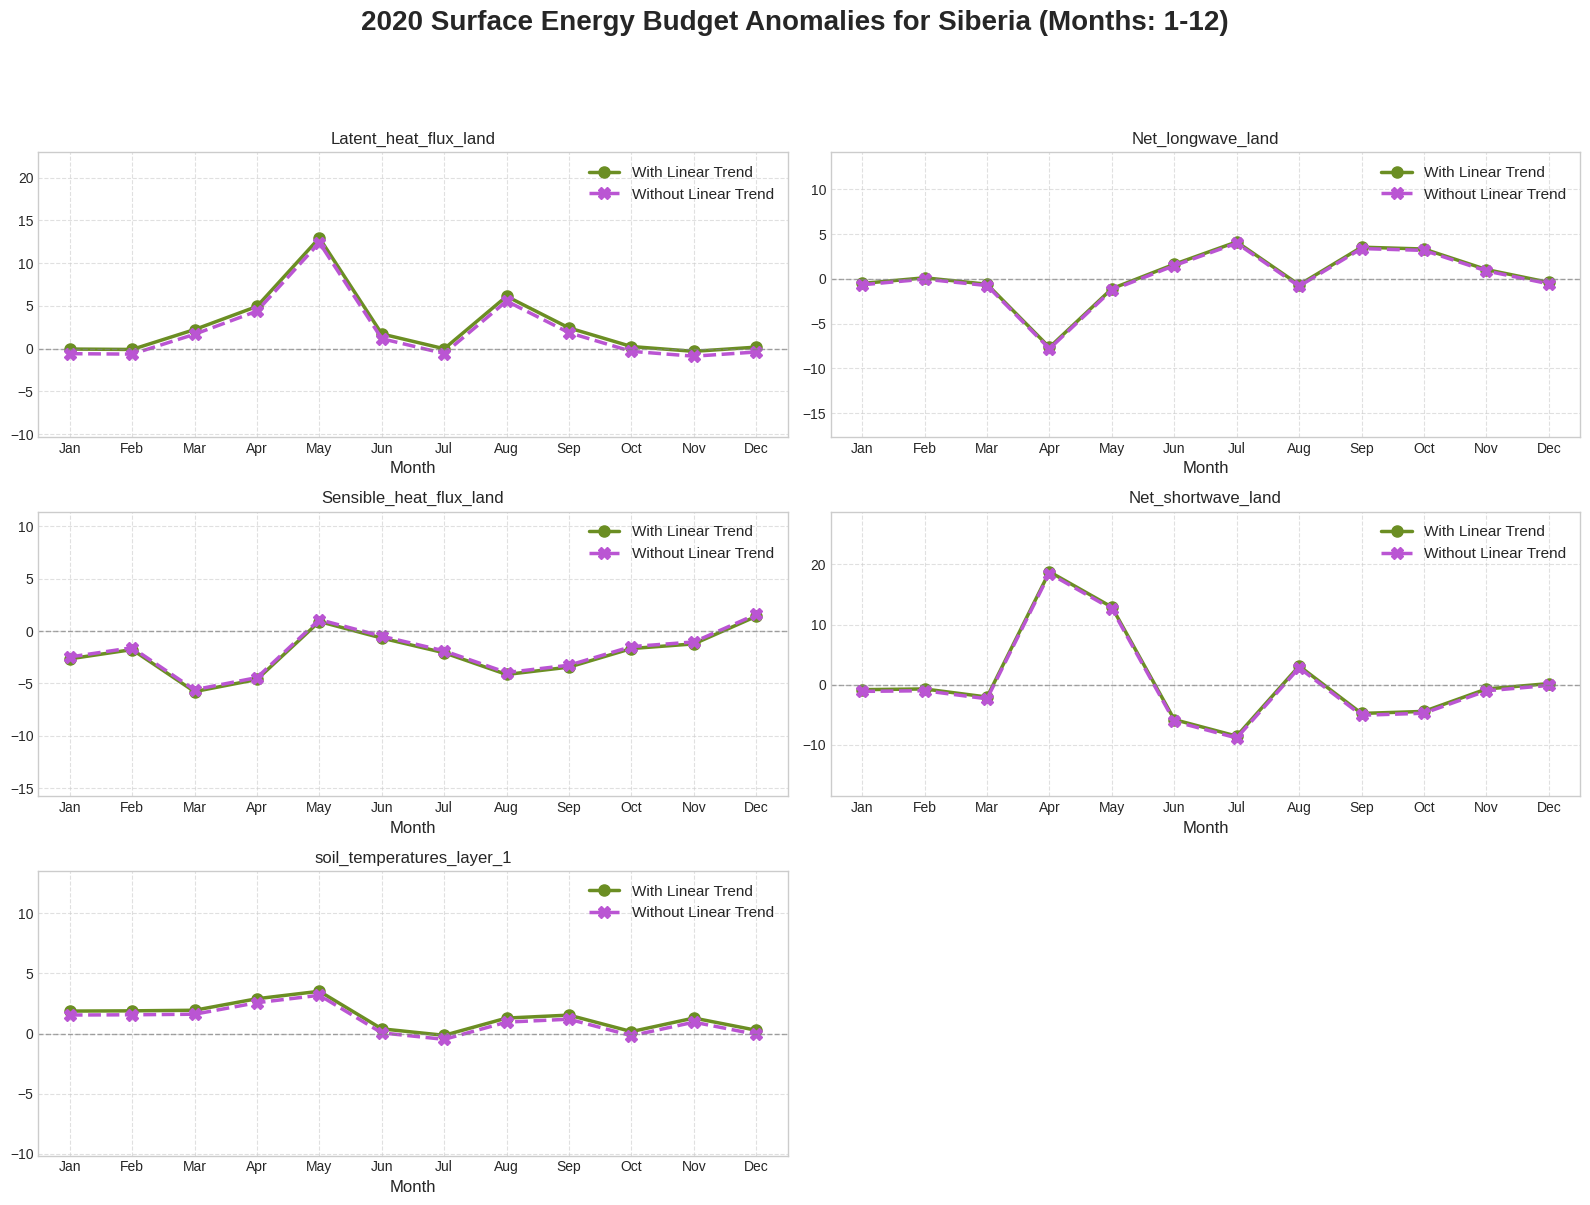

In [3]:
# Settings
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":12,
    "var":'avg_ishf'
    }

# Set up figure based on number variables to plot (but keep two columns)
var_list=list(ds.keys())
var_list=var_list[2:]
num_vars = len(var_list)

ncols = 2
nrows = math.ceil(num_vars / ncols)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows))
axes = axes.flatten()

for i, var in enumerate(var_list):
    # Calculations which loop over every variable
    kwargs['var'] = var
    merra2_anom, merra2_anomstd, merra2_anomdetrend, merra2_anomdetrendstd, _ = smg.calculate_detrended_stats(ds, supress=True, **kwargs)
    p1 = merra2_anom.sel(time="2020")
    p2 = merra2_anomdetrend.sel(time="2020")
    # ax.set_ylim((-15, 25))
    
    # # Plot
    ax = axes[i]
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title(ds[var].attrs['long_name'].removeprefix('Time-mean '), wrap=True)
    plt_mca.plot_2020_anomaly(p1, p2, ax=ax)
    ax.set_ylim((p1.min()-10, p1.max()+10))

# --- 4. Final Figure Cleanup ---
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

# Generate a dynamic title based on the selection
region_name = kwargs['region']['name'] if kwargs['region']['name'] else "Global"
season_name = f"Months: {kwargs['month_start']}-{kwargs['month_end']}"
fig.suptitle(f"2020 Surface Energy Budget Anomalies for {region_name} (Months: {kwargs['month_start']}-{kwargs['month_end']})\n", fontsize=20, weight='bold', y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Radiation (longwave, shortwave, sensible, latent, etc.)

In [4]:
path = "../../data0/yvu/MERRA-2/radiation/"
file = "merged-MERRA2RAD.nc4"
ds = xr.open_dataset(path+file).sortby('time')
ds = ds * lsm
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (lat: 361, lon: 576, time: 540)
Coordinates:
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 4kB 1980-01-01T00:30:00 ... 2024-12-01T00:...
Data variables:
    ALBEDO   (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... nan nan nan nan
    LWGAB    (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LWGEM    (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LWGNT    (time, lat, lon) float32 449MB -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    LWTUP    (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWGDN    (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWGNT    (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SWTNT    (time, lat, lon) float32 449MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/34)
    History:                           Wed Dec 10 22:27:40 2025: ncrcat MERRA...
    Filename:                          MERRA2_100.tavgM_2d_rad_Nx.198001.nc4
    Comment:                           GMAO filename: d5124_m2_jan79.tavg1_2d...
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   23:59:59.000000
    history:                           2025-12-10 23:43:00 GMT hyrax-1.17.1 h...
    history_json:                      [{"$schema":"https:\/\/harmony.earthda...
    DODS_EXTRA.Unlimited_Dimension:    time
    NCO:                               netCDF Operators version 5.0.6 (Homepa...

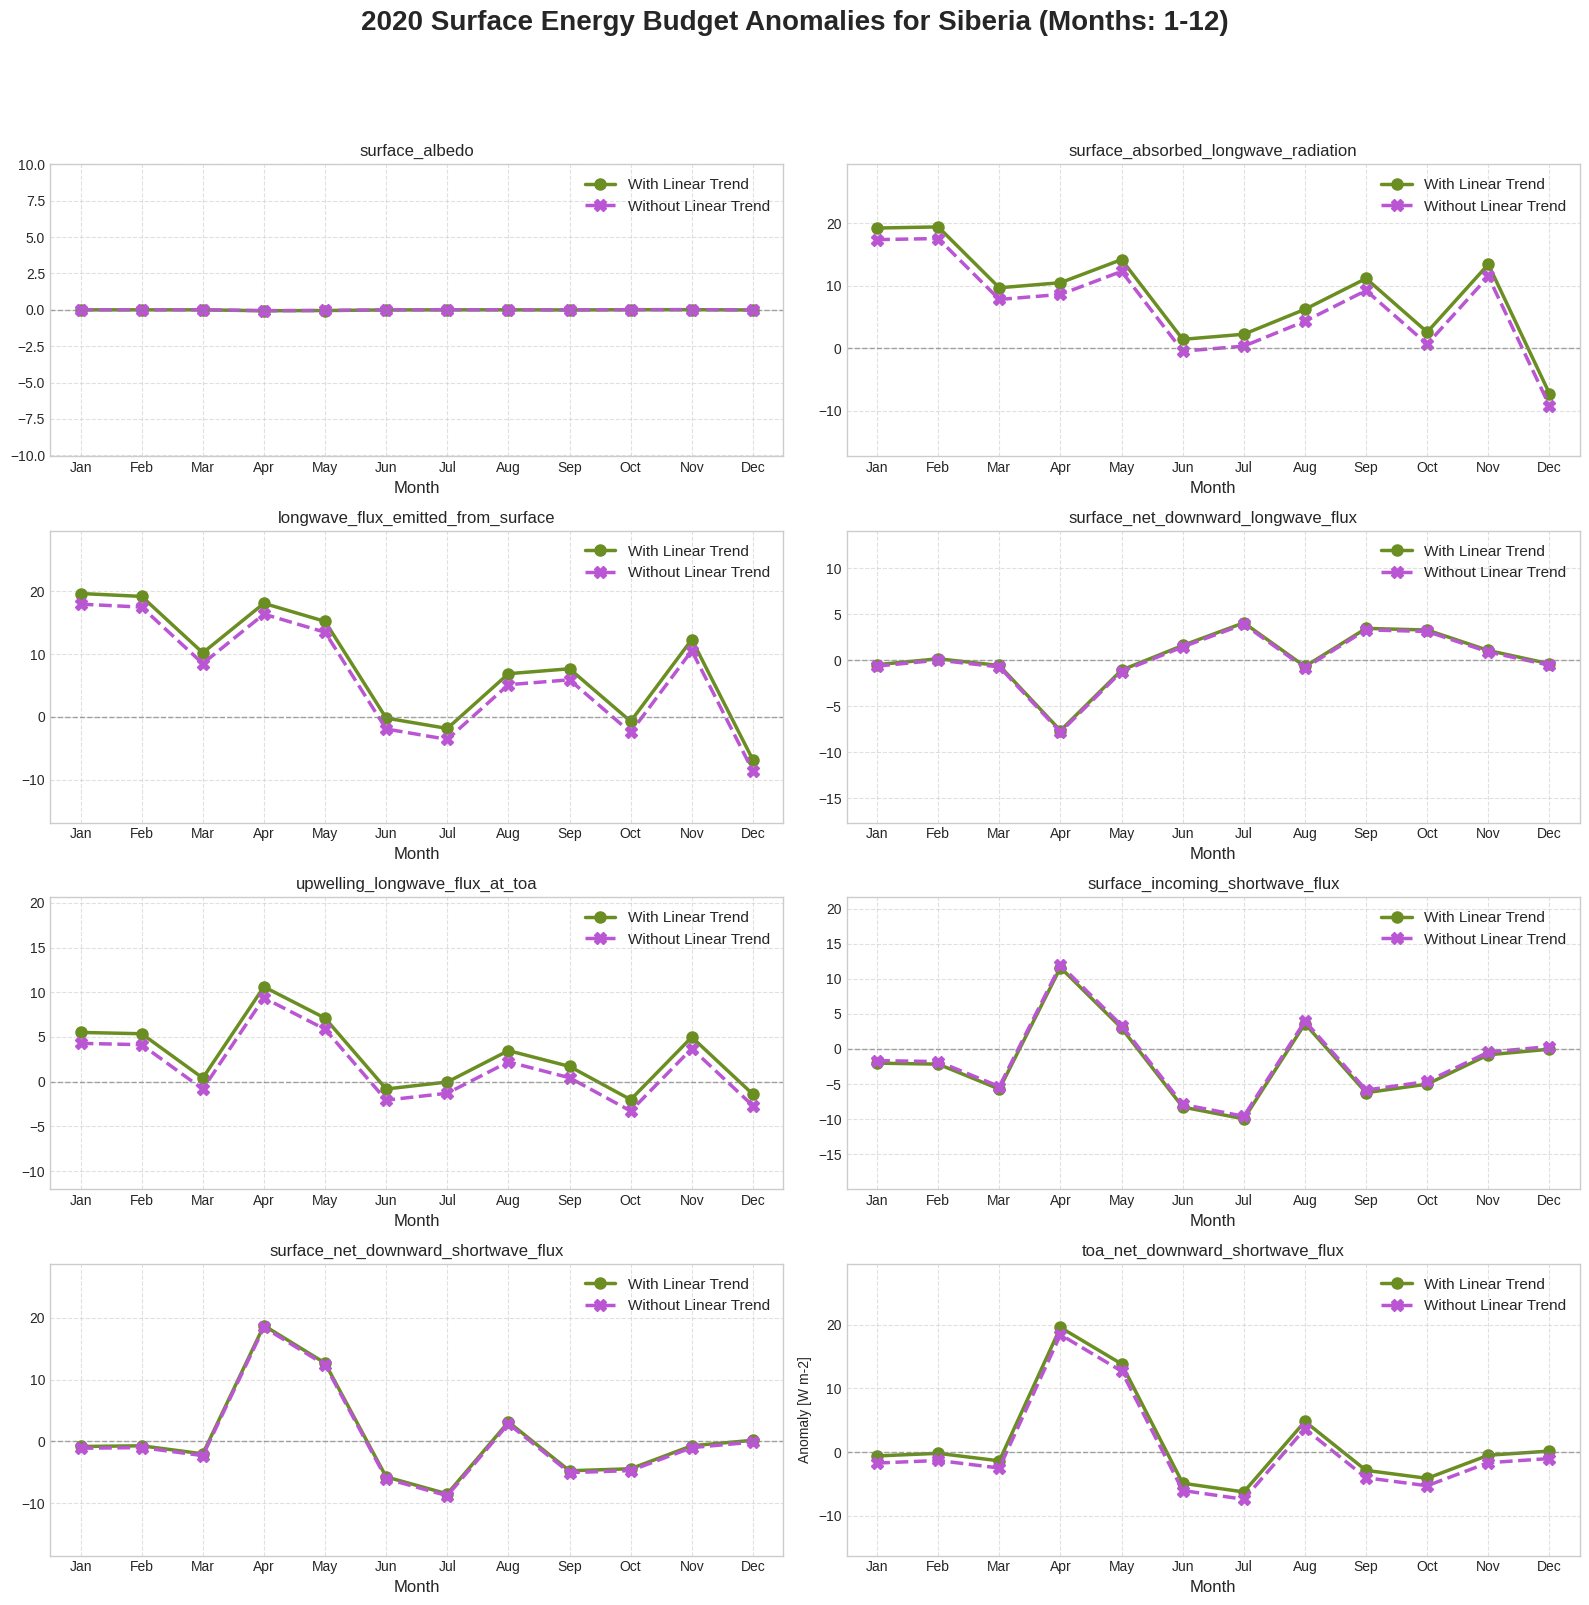

In [5]:
# Settings
kwargs={
    "region":smg.siberia,
    "month_start":1,
    "month_end":12,
    "var":'avg_ishf'
    }

# Set up figure based on number variables to plot (but keep two columns)
var_list=list(ds.keys())
# var_list=[]
num_vars = len(var_list)

ncols = 2
nrows = math.ceil(num_vars / ncols)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 4 * nrows))
axes = axes.flatten()

for i, var in enumerate(var_list):
    # Calculations which loop over every variable
    kwargs['var'] = var
    merra2_anom, merra2_anomstd, merra2_anomdetrend, merra2_anomdetrendstd, _ = smg.calculate_detrended_stats(ds, supress=True, **kwargs)
    p1 = merra2_anom.sel(time="2020")
    p2 = merra2_anomdetrend.sel(time="2020")
    # ax.set_ylim((-15, 25))
    
    # # Plot
    ax = axes[i]
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title(ds[var].attrs['long_name'].removeprefix('Time-mean '), wrap=True)
    plt_mca.plot_2020_anomaly(p1, p2, ax=ax)
    ax.set_ylim((p1.min()-10, p1.max()+10))

# --- 4. Final Figure Cleanup ---
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

# Generate a dynamic title based on the selection
region_name = kwargs['region']['name'] if kwargs['region']['name'] else "Global"
season_name = f"Months: {kwargs['month_start']}-{kwargs['month_end']}"
fig.suptitle(f"2020 Surface Energy Budget Anomalies for {region_name} (Months: {kwargs['month_start']}-{kwargs['month_end']})\n", fontsize=20, weight='bold', y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Temperature (2m)

In [6]:
path = "../../data0/yvu/MERRA-2/temperature/"
file = "merged-M2TMNXSLV.nc4"# just 2-m temperature
ds = xr.open_dataset(path+file).sortby('time')
ds = ds * lsm